In [34]:
# imports
import cfbd
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

In [35]:
#api configuration setup
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'INSERT YOUR OWN COLLEGE FOOTBALL DATA API KEY HERE'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_config = cfbd.ApiClient(configuration)

In [36]:
# global variables
team_api = None
ratings_api = None

In [37]:
def generate_apis(api_config):
    # set team_api
    global team_api
    team_api = cfbd.TeamsApi(api_config)

    # set ratings_api
    global ratings_api
    ratings_api = cfbd.RatingsApi(api_config)
    
    return None

In [38]:
def get_team_df(api_config, from_year, to_year, conf_list):
    global team_api
    if team_api == None:
        generate_apis(api_config)
        
    # local variables
    df_team = pd.DataFrame(columns=['id','school','abbreviation','conference','logos'])
    year = from_year
    
    # outer join team data from years in range [from_year, to_year]
    while year <= to_year:
        # get team data for each year
        team = team_api.get_fbs_teams(year=year)
        df_temp = pd.DataFrame.from_records([dict(id=t.id, 
                                         school=t.school, 
                                         abbreviation=t.abbreviation,
                                         conference=t.conference,
                                         logos=t.logos
                                        ) for t in team])
        
        # logos has dark mode and light mode logos, only keep light mode
        image_list = []
        for row in range(len(df_temp)):
            image_list.append(df_temp.iloc[row,4][0])
        df_temp['logos'] = pd.DataFrame(image_list)
        
        # join current year to overall dataframe
        df_team = pd.merge(df_team, df_temp, how='outer', on=['id','school','abbreviation','conference','logos'])
        
        # increment year
        year+=1
        
    # only keep teams in desired conferences
    df_team['in_conf_list'] = df_team.conference.apply(lambda x: 1 if x in conf_list else 0)
    df_team = df_team.loc[df_team["in_conf_list"] == 1]
    df_team = df_team.drop('in_conf_list', axis=1)
    
    return df_team

In [39]:
def get_elo_df(api_config, from_year, to_year):
    global ratings_api
    if ratings_api == None:
        generate_apis(api_config)
        
    # local variables
    df_elo = pd.DataFrame(columns=['team','conference','cumulative_elo','missing_elo','avg_elo'])
    year = from_year
    
    # outer join team data from years in range [from_year, to_year]
    while year <= to_year:
        # get elo data for each year
        ratings = ratings_api.get_elo_ratings(year=year)
        df_temp = pd.DataFrame.from_records([dict(team=r.team, 
                                     conference=r.conference,
                                     elo=r.elo
                                    ) for r in ratings])
        
        # rename elo to elo_year to make it unique
        df_temp.rename(columns={'elo':'elo_'+str(year)}, inplace=True)
        
        # join current year to overall dataframe
        df_elo = pd.merge(df_elo, df_temp, how='outer', on=['team','conference'])
        
        # replace nan with 0's
        df_elo.fillna(0, inplace=True)
        
        # check for missing elo data
        df_elo['missing_elo'] = df_elo['missing_elo'] | df_elo['elo_'+str(year)].apply(lambda x: True if x==0 else False)
            
        # add new year to cumulative_elo column
        df_elo['cumulative_elo'] += df_elo['elo_'+str(year)]
        
        # increment year
        year+=1
    
    # add new year to avg_elo column
    df_elo['avg_elo'] = df_elo['cumulative_elo'] / (to_year-from_year+1)
    
    # rename team to school (what it is in other dataframes)
    df_elo = df_elo.rename({'team': 'school'}, axis=1)
    
    return df_elo

In [40]:
def get_talent_df(api_config, from_year, to_year):
    global team_api
    if team_api == None:
        generate_apis(api_config)
        
    # local variables
    df_talent = pd.DataFrame(columns=['school','cumulative_talent','missing_talent','avg_talent'])
    year = from_year
    
    # outer join team data from years in range [from_year, to_year]
    while year <= to_year:
        # get talent data for each year
        team_talent = team_api.get_talent(year=year)
        df_temp = pd.DataFrame.from_records([dict(school=t.school, 
                                     talent=t.talent
                                    ) for t in team_talent])
        
        # rename talent to talent_year to make it unique
        df_temp.rename(columns={'talent':'talent_'+str(year)}, inplace=True)
        
        # join current year to overall dataframe
        df_talent = pd.merge(df_talent, df_temp, how='outer', on=['school'])
        
        # replace nan with 0's
        df_talent.fillna(0, inplace=True)
        
        # check for missing talent data
        df_talent['missing_talent'] = df_talent['missing_talent'] | df_talent['talent_'+str(year)].apply(lambda x: True if x==0 else False)
            
        # add new year to cumulative_talent column
        df_talent['cumulative_talent'] += df_talent['talent_'+str(year)]
        
        # increment year
        year+=1
    
    # add new year to avg_talent column
    df_talent['avg_talent'] = df_talent['cumulative_talent'] / (to_year-from_year+1)
    
    return df_talent

In [41]:
def get_dataframe(api_config, from_year, to_year, conf_list):
    """ Gets Power-5 schools elo ratings and composite talent ratings of a span
    of years. """

    # get separate dataframes
    team_df = get_team_df(api_config, from_year, to_year, conf_list)
    elo_df = get_elo_df(api_config, from_year, to_year)
    talent_df = get_talent_df(api_config, from_year, to_year)
    
    # join dataframes
    df = pd.merge(team_df, elo_df, how='left', on=['school','conference'])
    df = pd.merge(df, talent_df, how='left', on=['school'])

    return df

In [42]:
#source: https://github.com/feeblefruits/Pokemon/blob/master/poke_challenge-master/poke_scatter.ipynb
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom, resample=True)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

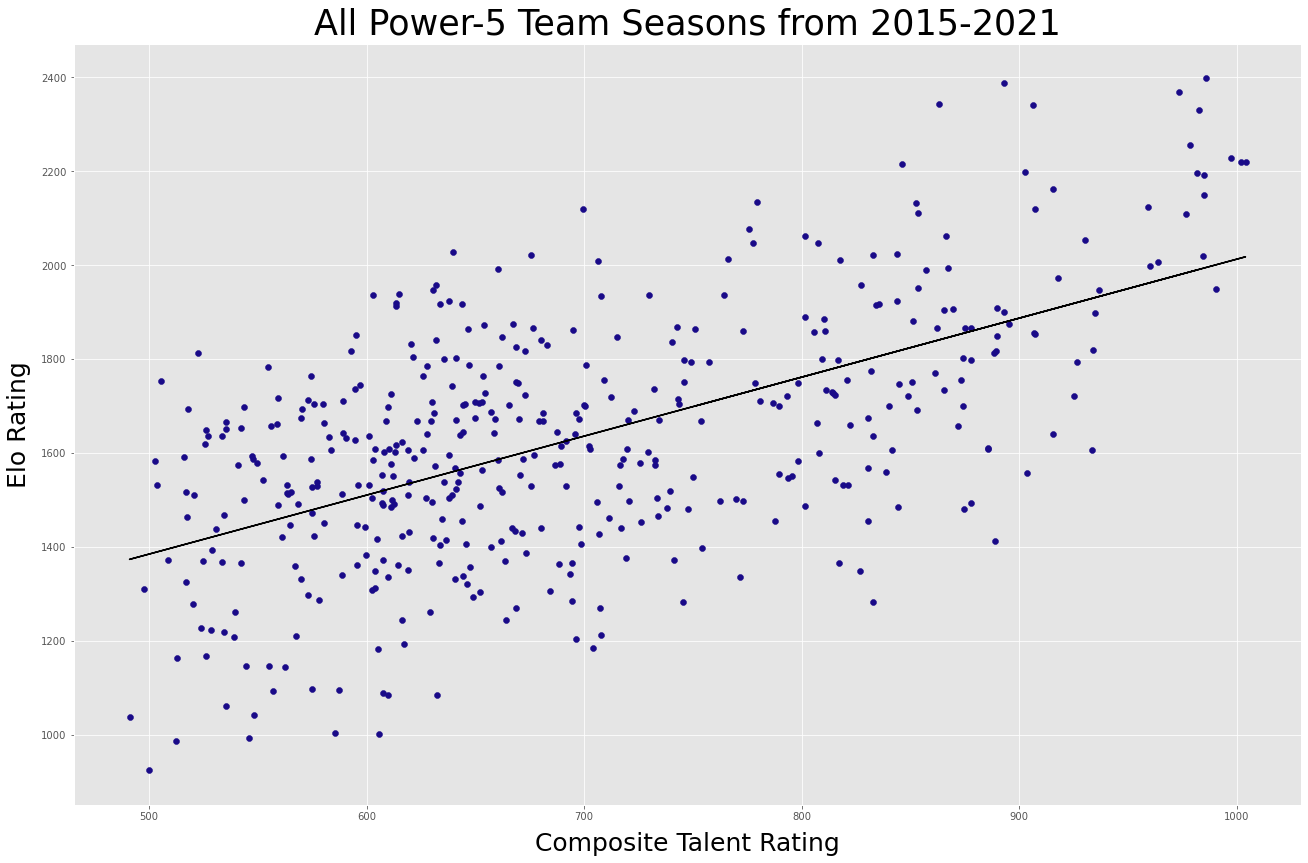

In [57]:
#plotting setup
plt.rcParams['figure.figsize'] = (22, 14)
plt.style.use(style='ggplot')
font = {'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 25,
    }

#get data for power-5 schools from 2015-2021
power_5 = ['SEC','Pac-12','ACC','Big Ten','Big 12']
df = get_dataframe(api_config,2015,2021, power_5)
df1 = get_dataframe(api_config,2019,2021, power_5)

#get data for trendline of elo vs talent (2015-2021)
year = 2015
df_trendline = pd.DataFrame(columns=['elo','talent'])
i=0
for i in range(7):
    df_temp = df.filter(['elo_'+str(year+i),'talent_'+str(year+i)], axis=1)
    df_temp = df_temp.rename({'elo_'+str(year+i):'elo', 'talent_'+str(year+i):'talent'}, axis=1)
    df_trendline = df_trendline.append(df_temp, ignore_index=True)

#trendline plot
trendline_x = df_trendline['talent']
trendline_y = df_trendline['elo']
plt.scatter(trendline_x, trendline_y,c='#190A88')
plt.xlabel("Composite Talent Rating",fontdict=font,labelpad=10)
plt.ylabel("Elo Rating",fontdict=font,labelpad=10)
plt.title("All Power-5 Team Seasons from 2015-2021", size=35,loc='center',pad=10)
#calculate equation for trendline
z = np.polyfit(trendline_x, trendline_y, 1)
p = np.poly1d(z)
#add trendline to plot
plt.plot(trendline_x, p(trendline_x), color='black')
plt.savefig('trendline.png')
plt.show()

In [ ]:
#clear plot figure
plt.clf()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_87014/1797761193.py:6: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  image = plt.imread(image)


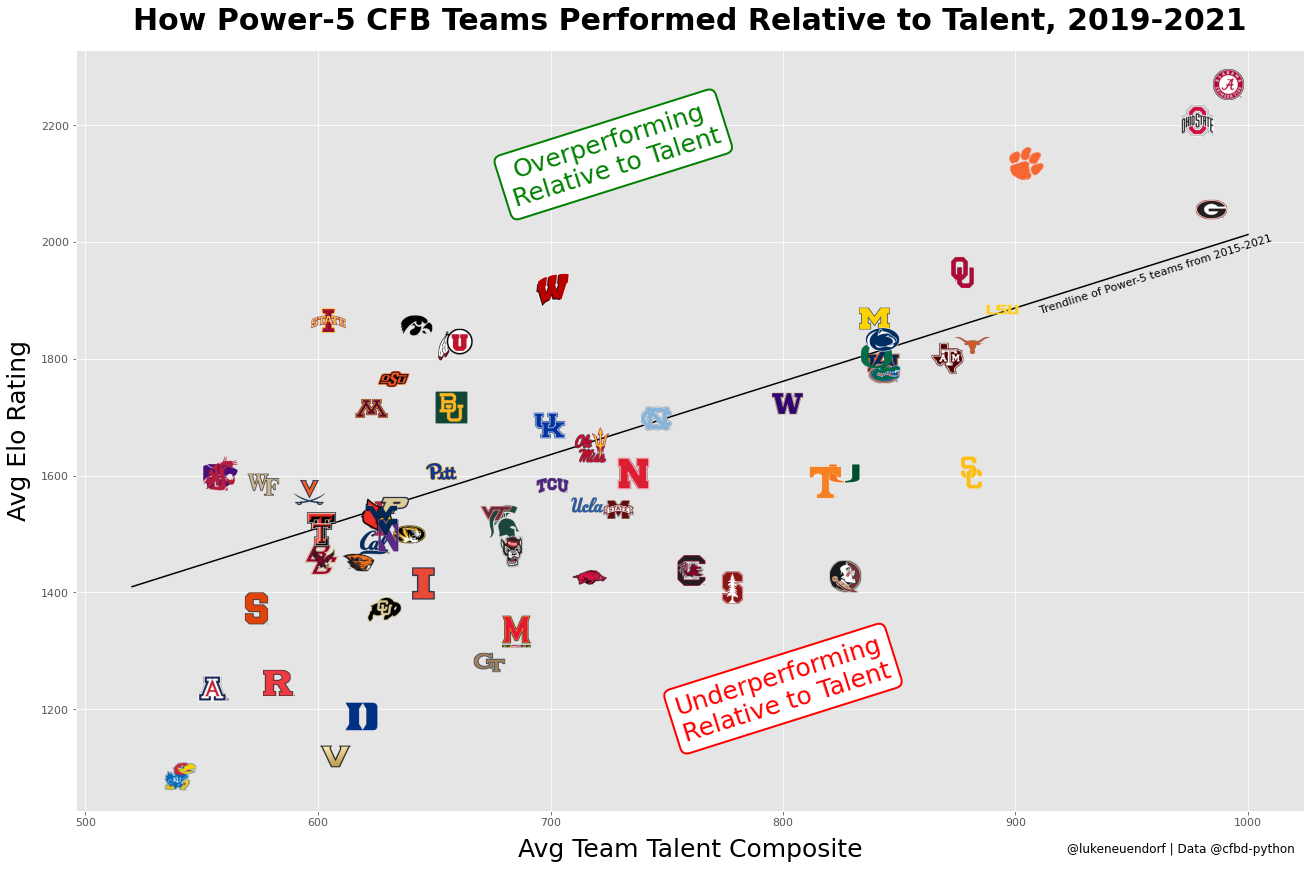

In [64]:
#cumulative elo vs talent rating 2019-2021 plot
fig, ax = plt.subplots()
#plot logos
for x, y, image_path in zip(df1['avg_talent'], df1['avg_elo'], df1['logos']):
    imscatter(x, y, image_path, zoom=0.07, ax=ax)
#labels
plt.xlabel("Avg Team Talent Composite", fontdict=font,labelpad=10)
plt.ylabel("Avg Elo Rating",fontdict=font,labelpad=10)
plt.title("How Power-5 CFB Teams Performed Relative to Talent, 2019-2021", fontdict=font, weight='bold',size=30,pad=20)
#overperforming annotation box
plt.text(800, 1235, "Underperforming\nRelative to Talent", horizontalalignment='center',verticalalignment='center',rotation=17.5, size=25, color='red', weight='normal',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="r", lw=2))
#underperforming annotation box
plt.text(727, 2150, "Overperforming\nRelative to Talent", horizontalalignment='center',verticalalignment='center', rotation=17.5, size=25, color='green', weight='normal',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="g", lw=2))
#add trendline to plot
x = np.linspace(520,1000,800)
y = 1.25657097*x+756.16919802 #trendline found in first plot
plt.plot(x, y, '-k')
#adjust tick mark text size
ax.tick_params(axis='both', which='major', labelsize=11)
#add trendline annotation
plt.text(910,1945,'Trendline of Power-5 teams from 2015-2021',
         horizontalalignment='left',
         verticalalignment='center',
         rotation=17.5, size=11, color='black', weight='normal')
#add author and source tags
plt.text(1020,960,'@lukeneuendorf | Data @cfbd-python',
         horizontalalignment='right',
         verticalalignment='center',
         size=12, color='black', weight='normal')
plt.savefig('elo_vs_talent.png')
plt.show()